# Thermal Image Animal Segmentation

Implementing animal boundary detection using traditional CV methods and comparing with SAM2.

## Installation

In [1]:
# Installing PyTorch
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

In [2]:
# Cloning SAM2 repository
import os
if not os.path.exists('segment-anything-2'):
    !git clone https://github.com/facebookresearch/segment-anything-2.git

In [3]:
# Installing SAM2
# !pip install -e ./segment-anything-2

## Imports

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

try:
    from sam2.build_sam import build_sam2
    from sam2.sam2_image_predictor import SAM2ImagePredictor
    from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
    sam2_available = True
except ImportError:
    sam2_available = False
    print("SAM2 not available")

%matplotlib inline

## Configuration

In [5]:
# Path to thermal image
image_path = os.path.join("thermal_images", "thermal_giraffe.jpg")

# Figure size
figure_width = 20
figure_height = 12

## Traditional CV Approach: Methodology and Rationale

### Algorithm Selection: GrabCut with Foreground Hints

The traditional computer vision approach uses **GrabCut**, a graph-cut based segmentation algorithm, combined with intensity-based foreground hints. This method was selected after testing several alternatives:

**Attempted Methods:**
1. **Adaptive Thresholding** - Failed to separate giraffe from warm ground regions
2. **Otsu Thresholding alone** - Captured body well but missed cooler extremities (legs, tail, nose)
3. **Morphological Reconstruction** - Connected body parts but included too much background noise
4. **Multi-threshold approach** - Better results but still struggled with boundary precision

**Final Method: GrabCut with Hints**

GrabCut was chosen because it:
- Models foreground/background as probability distributions rather than simple thresholds
- Iteratively refines boundaries based on color/intensity similarity
- Can incorporate user hints about definite foreground regions

### Implementation Steps

**1. Initial Detection (Otsu Thresholding)**
- Applies automatic thresholding to find approximate object location
- Multiplier (0.8) adjusts threshold to balance sensitivity
- Provides bounding box for GrabCut initialization

**2. Foreground Hints**
- Identifies very bright pixels (>120 intensity) as definite giraffe regions
- Erodes these regions to be conservative (avoid including boundary noise)
- Guides GrabCut to focus uncertainty on edges, not core body

**3. GrabCut Segmentation**
- Learns color models for foreground (giraffe) and background
- Iteratively optimizes boundary using graph cuts
- Produces pixel-level segmentation mask

**4. Post-Processing**
- Morphological closing fills small internal gaps
- Morphological opening removes small external noise
- Produces final clean contour

### Limitations

**Thermal Imaging Challenges:**
- Giraffe's feet have similar temperature to ground, making separation difficult
- Even human observers struggle to distinguish boundary at the feet
- Traditional CV reaches its limits where thermal contrast is insufficient

**Why This Matters:**
This represents the practical ceiling of non-learning methods. The ground-truth boundary at the feet is ambiguous even in the raw thermal data, highlighting why deep learning approaches (SAM2) may provide better results through learned priors about animal shapes.## Traditional CV Segmentation

Initial detection: 1 regions, using bbox: (155,46,485,404)


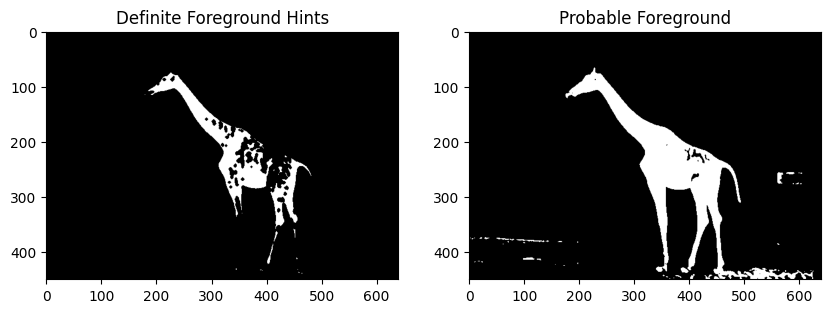

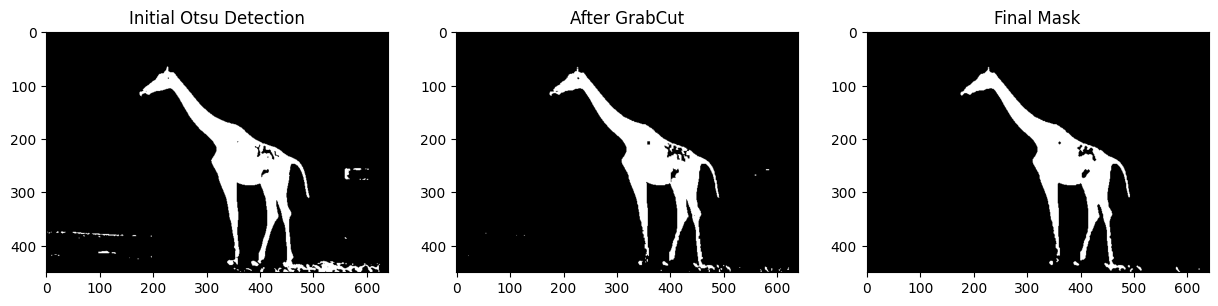

Traditional CV: 1 regions detected
Segmented: 8.22% of image


In [6]:
# ============ TUNABLE PARAMETERS ============
# Initial detection thresholds
OTSU_MULTIPLIER = 0.8     # Multiply Otsu threshold (0.8 = 80% of auto threshold)
MIN_AREA_PERCENT = 0.03   # Minimum contour area to consider

# GrabCut parameters
GRABCUT_ITERATIONS = 5    # More iterations = better refinement
MARGIN_EXPAND = 20        # Pixels to expand bounding box for GrabCut

# Foreground hint parameters
USE_FG_HINTS = True       # Use bright regions as definite foreground
FG_THRESHOLD = 120        # Pixels brighter than this are definitely giraffe
FG_ERODE = 3              # Erode FG mask to be conservative

# Post-processing
FINAL_MORPH_KERNEL = 3    # Kernel size for final cleanup
FINAL_CLOSE_ITER = 2      # Close small holes
# ============================================

# Load image
thermal_image_bgr = cv2.imread(image_path)
if thermal_image_bgr is None:
    raise FileNotFoundError(f"Could not load {image_path}")

thermal_image_rgb = cv2.cvtColor(thermal_image_bgr, cv2.COLOR_BGR2RGB)
thermal_image_gray = cv2.cvtColor(thermal_image_bgr, cv2.COLOR_BGR2GRAY)
image_height, image_width = thermal_image_gray.shape
total_image_area = image_width * image_height

# Step 1: Initial rough detection using Otsu
blurred = cv2.GaussianBlur(thermal_image_gray, (5, 5), 0)
otsu_val, otsu_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Use modified Otsu threshold
threshold_val = otsu_val * OTSU_MULTIPLIER
_, initial_mask = cv2.threshold(blurred, threshold_val, 255, cv2.THRESH_BINARY)

# Find the main object bounding box
contours, _ = cv2.findContours(initial_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = total_image_area * MIN_AREA_PERCENT

# Get largest contour
valid_contours = [c for c in contours if cv2.contourArea(c) > min_area]
if not valid_contours:
    valid_contours = contours

largest_contour = max(valid_contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)

# Expand bounding box with margin
x = max(0, x - MARGIN_EXPAND)
y = max(0, y - MARGIN_EXPAND)
w = min(image_width - x, w + 2 * MARGIN_EXPAND)
h = min(image_height - y, h + 2 * MARGIN_EXPAND)

print(f"Initial detection: {len(valid_contours)} regions, using bbox: ({x},{y},{w},{h})")

# Step 2: Create foreground hints (definite giraffe regions)
mask = np.zeros((image_height, image_width), np.uint8)

if USE_FG_HINTS:
    # Find very bright regions - definitely part of giraffe
    _, fg_sure = cv2.threshold(blurred, FG_THRESHOLD, 255, cv2.THRESH_BINARY)
    
    # Erode to be conservative (only core bright regions)
    kernel_fg = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (FG_ERODE, FG_ERODE))
    fg_sure = cv2.erode(fg_sure, kernel_fg, iterations=2)
    
    # Set these as definite foreground in GrabCut mask
    mask[fg_sure == 255] = cv2.GC_FGD  # Definite foreground
    mask[(fg_sure == 0) & (initial_mask == 255)] = cv2.GC_PR_FGD  # Probable foreground
    
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(fg_sure, cmap='gray')
    plt.title('Definite Foreground Hints')
    plt.subplot(122)
    plt.imshow(initial_mask, cmap='gray')
    plt.title('Probable Foreground')
    plt.show()

bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)
rect = (x, y, w, h)

# Run GrabCut with foreground hints
if USE_FG_HINTS:
    cv2.grabCut(thermal_image_bgr, mask, rect, bgd_model, fgd_model, GRABCUT_ITERATIONS, cv2.GC_INIT_WITH_MASK)
else:
    cv2.grabCut(thermal_image_bgr, mask, rect, bgd_model, fgd_model, GRABCUT_ITERATIONS, cv2.GC_INIT_WITH_RECT)

# Extract foreground
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
final_refined_mask = mask2 * 255

# Step 3: Post-processing cleanup
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (FINAL_MORPH_KERNEL, FINAL_MORPH_KERNEL))
final_refined_mask = cv2.morphologyEx(final_refined_mask, cv2.MORPH_CLOSE, kernel, iterations=FINAL_CLOSE_ITER)
final_refined_mask = cv2.morphologyEx(final_refined_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# Show masks
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(initial_mask, cmap='gray')
plt.title('Initial Otsu Detection')
plt.subplot(132)
plt.imshow(mask2 * 255, cmap='gray')
plt.title('After GrabCut')
plt.subplot(133)
plt.imshow(final_refined_mask, cmap='gray')
plt.title('Final Mask')
plt.show()

# Find final contours
contours, _ = cv2.findContours(final_refined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
significant_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

# Create final mask
traditional_mask = np.zeros((image_height, image_width), dtype=np.uint8)
cv2.drawContours(traditional_mask, significant_contours, -1, 255, -1)

# Draw results
traditional_result = thermal_image_rgb.copy()
cv2.drawContours(traditional_result, significant_contours, -1, (0, 255, 0), 4)
for c in significant_contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(traditional_result, (x, y), (x+w, y+h), (255, 0, 0), 3)

print(f"Traditional CV: {len(significant_contours)} regions detected")
print(f"Segmented: {np.sum(traditional_mask==255)/total_image_area*100:.2f}% of image")

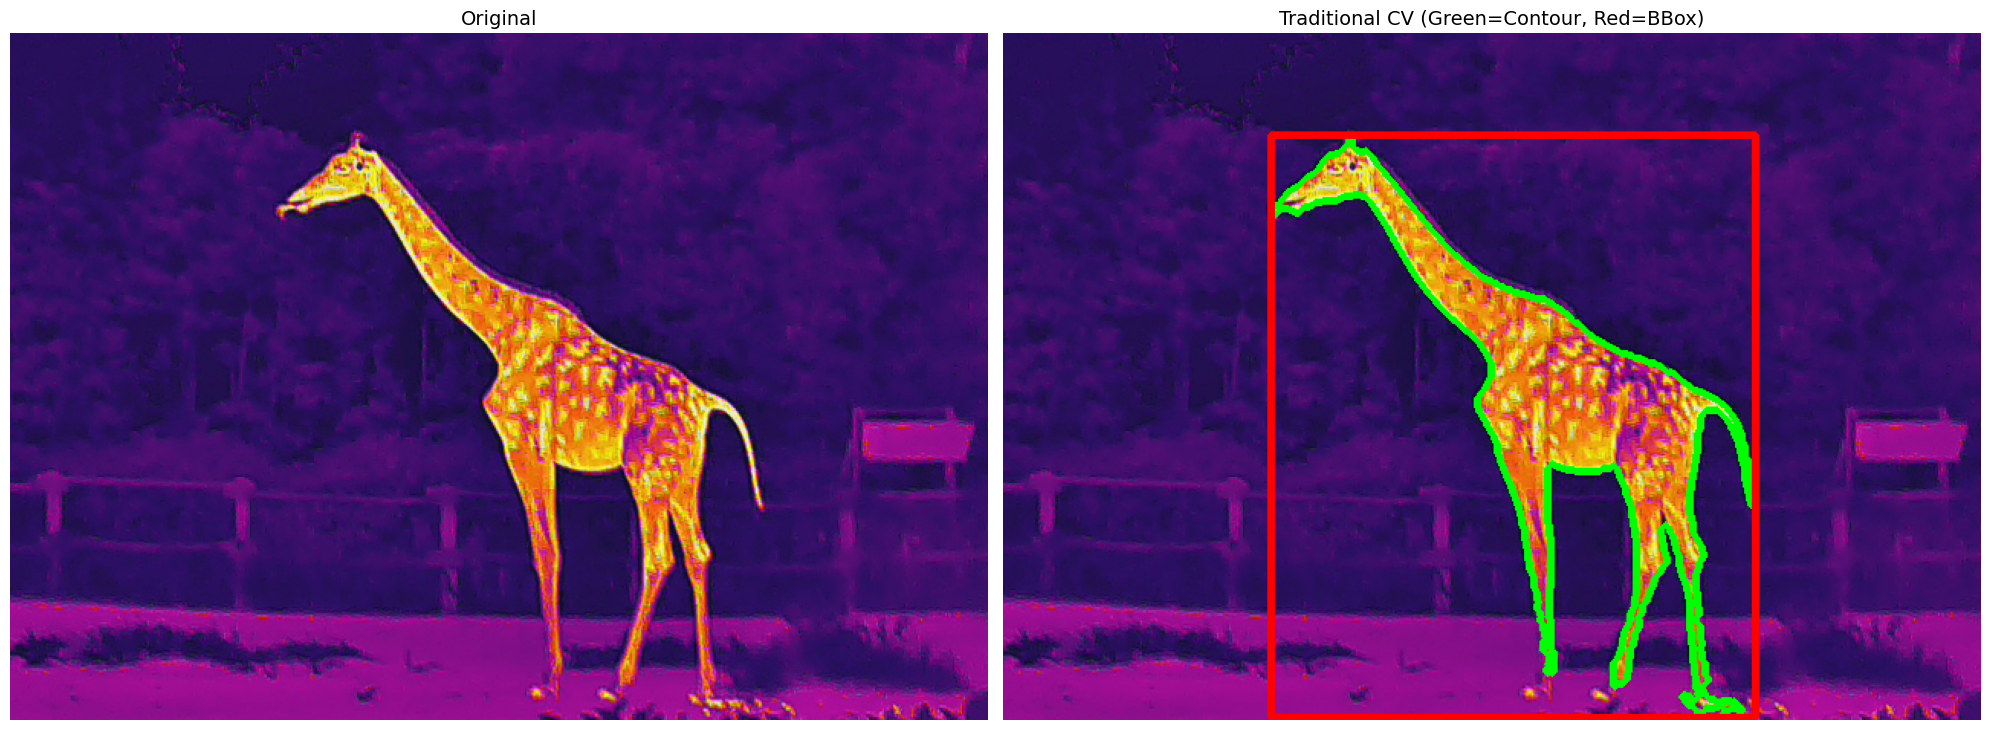

In [7]:
# Visualize traditional CV results
fig, axes = plt.subplots(1, 2, figsize=(figure_width, figure_height))
axes[0].imshow(thermal_image_rgb)
axes[0].set_title('Original', fontsize=14)
axes[0].axis('off')
axes[1].imshow(traditional_result)
axes[1].set_title('Traditional CV (Green=Contour, Red=BBox)', fontsize=14)
axes[1].axis('off')
plt.tight_layout()
plt.show()

## SAM2 Segmentation

In [8]:
# # Restart kernel to clear Hydra
# import os
# os._exit(00)

In [11]:
import os
import sys
import numpy as np
import cv2
import torch

# Clear any existing Hydra instance
from hydra import initialize_config_dir, compose
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from hydra.utils import instantiate

GlobalHydra.instance().clear()

# Add SAM2 to path
sys.path.insert(0, 'segment-anything-2')

# Load image first
thermal_image_bgr = cv2.imread(os.path.join("thermal_images", "thermal_giraffe.jpg"))
thermal_image_rgb = cv2.cvtColor(thermal_image_bgr, cv2.COLOR_BGR2RGB)
image_height, image_width = thermal_image_rgb.shape[:2]
total_image_area = image_width * image_height

# Build model manually without using build_sam2
checkpoint_path = os.path.join("segment-anything-2", "checkpoints", "sam2.1_hiera_small.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Hydra and keep it active
config_dir = os.path.abspath(os.path.join("segment-anything-2", "sam2", "configs"))
initialize_config_dir(config_dir=config_dir, version_base=None)

# Compose config
cfg = compose(config_name="sam2.1/sam2.1_hiera_s.yaml")
OmegaConf.resolve(cfg)

# Build model from config
print("Building SAM2 model...")
sam2_model = instantiate(cfg.model, _recursive_=True)
sam2_model = sam2_model.to(device)

# Load checkpoint weights
with open(checkpoint_path, "rb") as f:
    state_dict = torch.load(f, map_location=device)
sam2_model.load_state_dict(state_dict["model"])
sam2_model.eval()

# Create mask generator
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=32,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.85,
    min_mask_region_area=100,
)

print("Generating SAM2 masks...")
masks = mask_generator.generate(thermal_image_rgb)
masks = sorted(masks, key=lambda x: x['area'], reverse=True)

# Create combined mask
sam2_mask = np.zeros((image_height, image_width), dtype=np.uint8)
for m in masks[:5]:
    sam2_mask[m['segmentation']] = 255

# Create visualization
import matplotlib.pyplot as plt
sam2_visual = thermal_image_rgb.copy()
colors = [[255,0,0], [0,255,0], [0,0,255], [255,255,0], [255,0,255]]
for idx, m in enumerate(masks[:5]):
    sam2_visual[m['segmentation']] = colors[idx % 5]
sam2_visual = cv2.addWeighted(thermal_image_rgb, 0.5, sam2_visual, 0.5, 0)

print(f"SAM2: {len(masks)} masks generated")
print(f"Segmented: {np.sum(sam2_mask==255)/total_image_area*100:.2f}% of image")

# Clear Hydra when done
GlobalHydra.instance().clear()

Building SAM2 model...
Generating SAM2 masks...


C:\Users\jacob\OneDrive\Documents\School\Spring 2026\Computer Vision\Module 4\segment-anything-2\sam2\sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (C:\Users\jacob\OneDrive\Documents\School\Spring 2026\Computer Vision\Module 4\segment-anything-2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


SAM2: 18 masks generated
Segmented: 12.97% of image


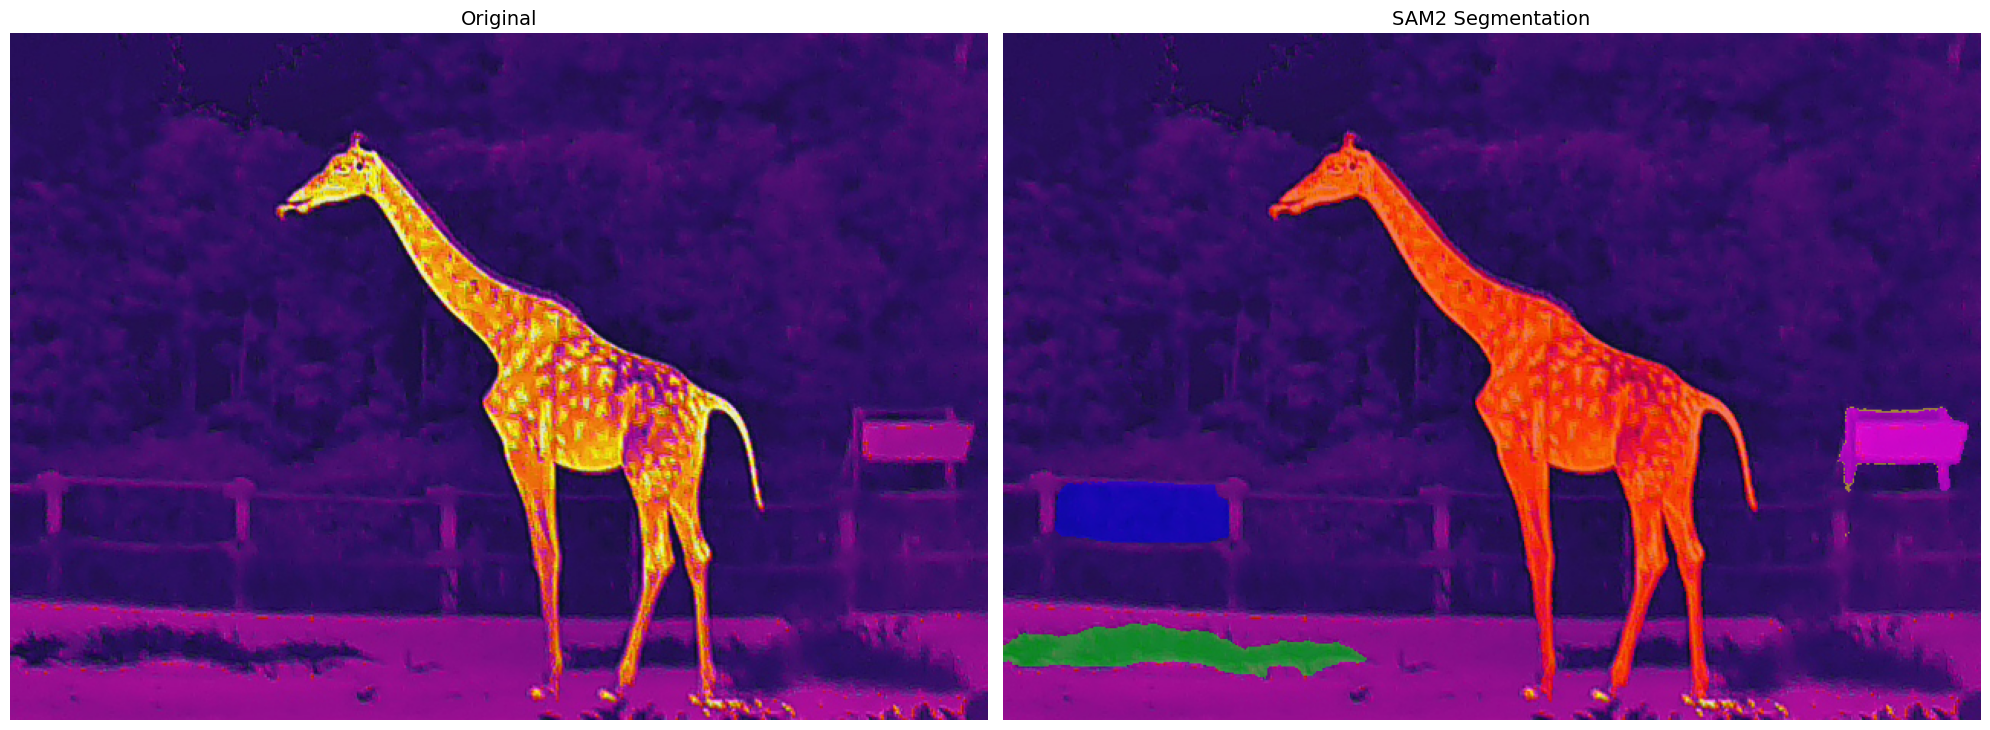

In [12]:
if sam2_available:
    # Visualize SAM2 results
    fig, axes = plt.subplots(1, 2, figsize=(figure_width, figure_height))
    axes[0].imshow(thermal_image_rgb)
    axes[0].set_title('Original', fontsize=14)
    axes[0].axis('off')
    axes[1].imshow(sam2_visual)
    axes[1].set_title('SAM2 Segmentation', fontsize=14)
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

## Comparison

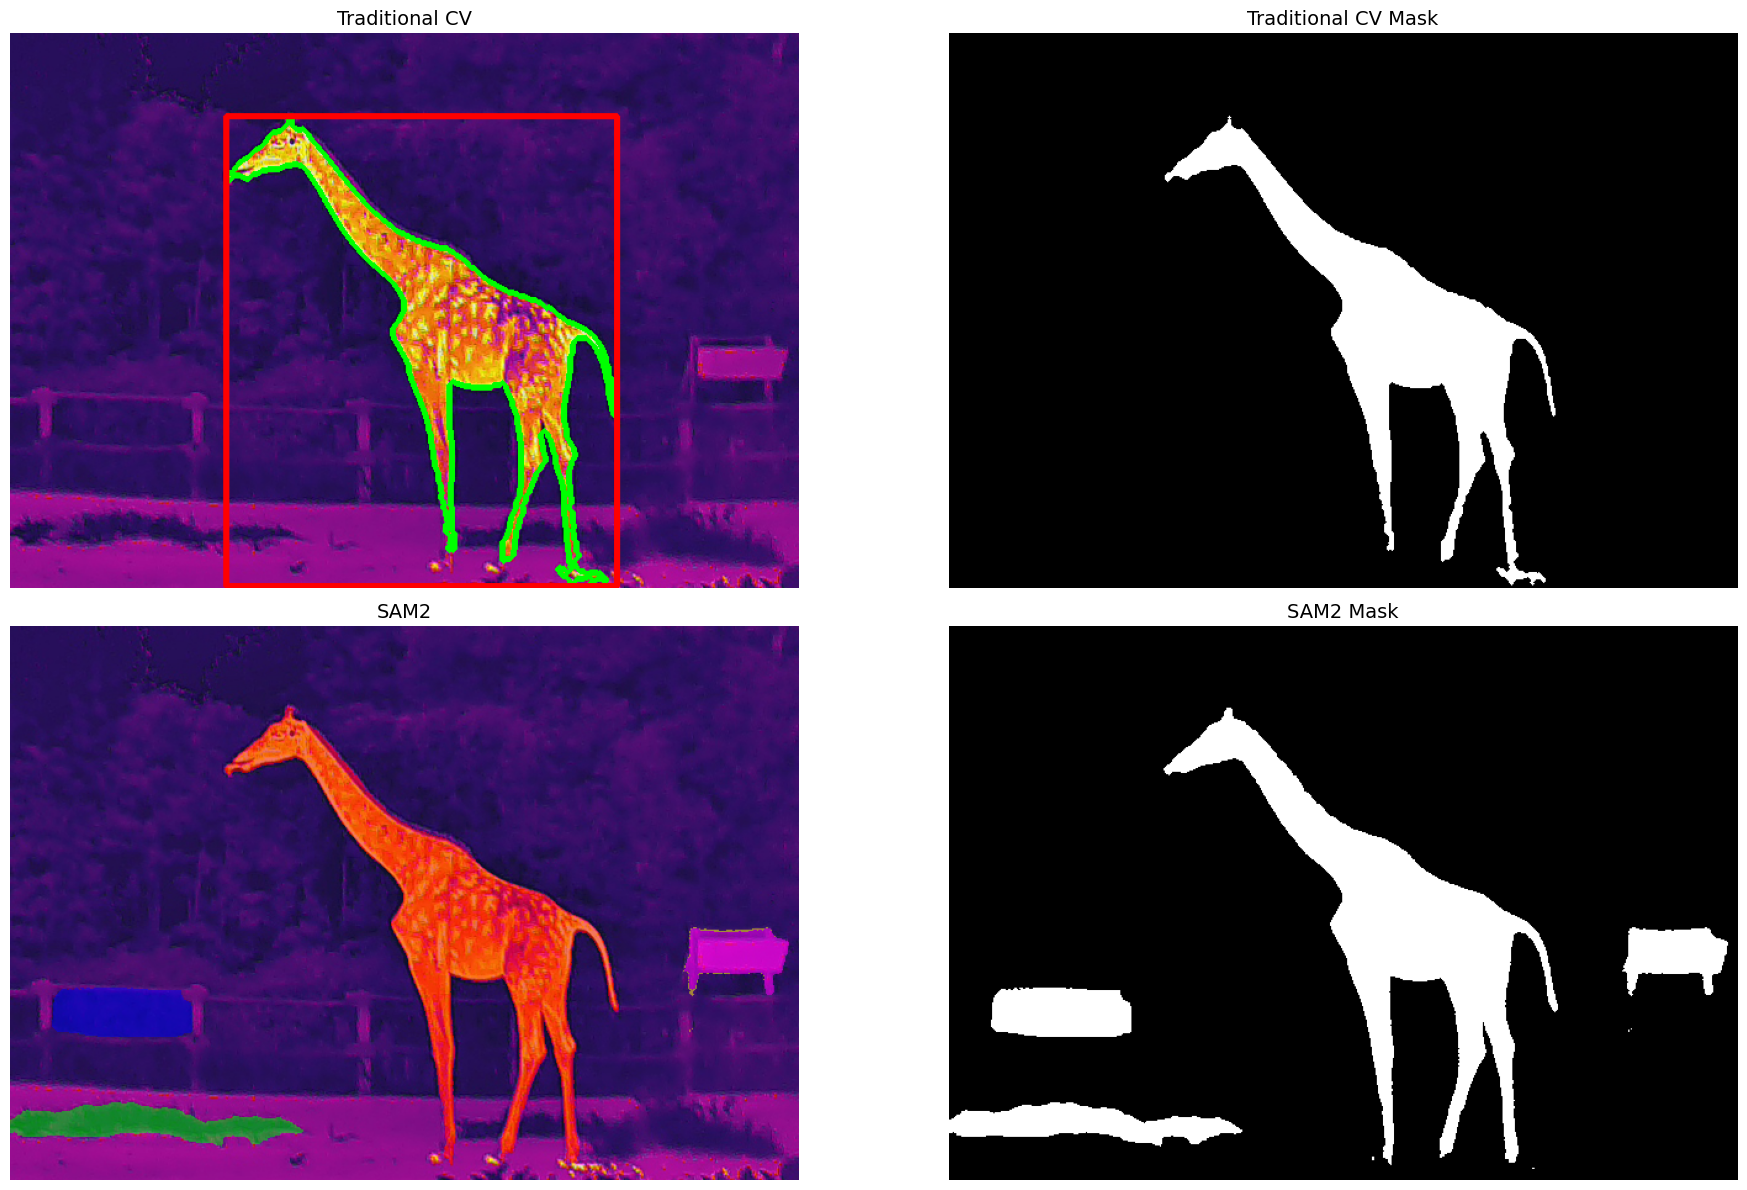


Comparison Metrics:
IoU: 0.6217
Dice: 0.7667


In [13]:
if sam2_available:
    # Side-by-side comparison
    fig, axes = plt.subplots(2, 2, figsize=(figure_width, figure_height))
    
    axes[0, 0].imshow(traditional_result)
    axes[0, 0].set_title('Traditional CV', fontsize=14)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(traditional_mask, cmap='gray')
    axes[0, 1].set_title('Traditional CV Mask', fontsize=14)
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(sam2_visual)
    axes[1, 0].set_title('SAM2', fontsize=14)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(sam2_mask, cmap='gray')
    axes[1, 1].set_title('SAM2 Mask', fontsize=14)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    intersection = np.logical_and(traditional_mask == 255, sam2_mask == 255)
    union = np.logical_or(traditional_mask == 255, sam2_mask == 255)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    
    dice = 2 * np.sum(intersection) / (np.sum(traditional_mask==255) + np.sum(sam2_mask==255))
    
    print(f"\nComparison Metrics:")
    print(f"IoU: {iou:.4f}")
    print(f"Dice: {dice:.4f}")